# Team Challenge 17 - Pipelines - Team Liberty

Importación de librerías:

In [51]:
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb

from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder

warnings.filterwarnings('ignore')

## 📌 Índice

#### 1. Problema de negocio y tema  

#### 2. Estructura del análisis  
* ##### 2.1 Análisis numérico  
* ##### 2.2 Tratamiento de los Outliers  
* ##### 2.3 Análisis categórico  

#### 3. Separación y codificación  
* ##### 3.1 Transformaciones  
* ##### 3.2 Pipeline y guardado  

#### 4. Modelos y métricas de evaluación 
* ##### 4.1 🔍 Supervisado - Random Forest  
* ##### 4.2 📊 No supervisado - PCA  

#### 5. 🏁 Conclusiones  


## 1. Problema de negocio y tema

En este estudio, nuestro objetivo es predecir el **salario** de profesionales en ciencia de datos en función de diversas variables relacionadas con el trabajo, la experiencia y la ubicación.

Hemos elegido el conjunto de datos *"Salarios de ciencia de datos 2023"* porque:
Contiene información relevante como: título del trabajo, nivel de experiencia, tipo de empleo, ubicación de la empresa y salario.

Incluye variables numéricas y categóricas, lo que permite aplicar técnicas de preprocesamiento como PCA (no supervisado) y modelos de regresión (supervisado).

El salario es una variable continua, lo que nos lleva a un problema de regresión en lugar de clasificación.
Es útil en la vida real: entender qué factores influyen en el salario puede ayudar tanto a compañeros como a profesionales de datos.
 

DATASET: https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023

In [52]:
df=pd.read_csv("./data/ds_salaries.csv")
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


## 2. Estructura del análisis  

### EXPLORACIÓN Y ANÁLISIS DE LOS DATOS

Vamos a analizar las variables rápidamente:

* **work_year**: Año en que se registró el salario (**numérica**, pero más bien categórica).

* **experience_level**: Nivel de experiencia del trabajador (categórica).
* **employment_type**: Tipo de empleo (categórica: full-time, part-time, etc.).
* **job_title**: Título del trabajo (categórica).
* **salary**: Salario en la moneda local de la empresa (**numérica**).
* **salary_currency**: Moneda del salario original (categórica).
* **salary_in_usd**: Salario convertido a USD (nuestro target, **numérica**).
* **employee_residence**: País de residencia del empleado (categórica).
* **remote_ratio**: Porcentaje de trabajo remoto (**numérica**: 0, 50, 100).
* **company_location**: País donde está la empresa (categórica).
* **company_size**: Tamaño de la empresa (categórica: S, M, L).

#### 2.1 Análisis numérico

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [54]:
# Modficamos la variable Salario que viene como object
print(df["salary"].dtype)  # Si es object, hay que convertirla
df["salary"] = pd.to_numeric(df["salary"], errors="coerce")  # Convierte a número

int64


In [55]:
# Hacemos un describe para ver la pinta de las variables numéricas
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [56]:
# Elegimos la variable target para nuestro modelo
target="salary_in_usd"

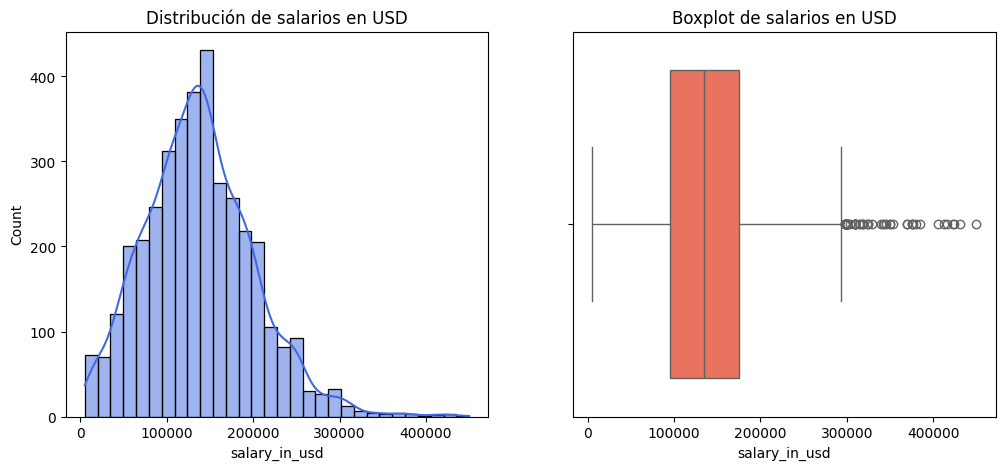

In [108]:
# Visualizamos la varible target mediante un histplot y un boxplot para ver sus outliers

# Ajustar el tamaño de las gráficas y los colores
palette = sns.color_palette("cubehelix", n_colors=10)
plt.figure(figsize=(12, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df["salary_in_usd"], bins=30, kde=True, color="royalblue")
plt.title("Distribución de salarios en USD")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df["salary_in_usd"], color="tomato")
plt.title("Boxplot de salarios en USD")

plt.show()

In [58]:
# Recordamos las columnas del DataFrame
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [59]:
# Seleccionamos solo las variables numéricas
numerical_cols = ["salary", "salary_in_usd", "remote_ratio",'work_year']  # Excluimos work_year por ser más categórica

# Calculamos la correlación en valor absoluto con el target
correlation_values = df[numerical_cols].corr()["salary_in_usd"].abs().sort_values(ascending=False)

# Mostramos los resultados
print(correlation_values)

salary_in_usd    1.000000
work_year        0.228290
remote_ratio     0.064171
salary           0.023676
Name: salary_in_usd, dtype: float64


#### ⚠️ Aquí se detecta algo raro ⚠️
➡️ No tiene sentido que la variable salario no tenga relación con el target, esto puede ser por que ya este bien hecho el cambio de moneda en salary_usd.

Así que lo comprobamos:

In [60]:
print(df["salary_currency"].value_counts())  # Frecuencia de cada moneda
print(df["salary_currency"].unique())  # Lista de monedas únicas

salary_currency
USD    3224
EUR     236
GBP     161
INR      60
CAD      25
AUD       9
SGD       6
BRL       6
PLN       5
CHF       4
HUF       3
DKK       3
JPY       3
TRY       3
THB       2
ILS       1
HKD       1
CZK       1
MXN       1
CLP       1
Name: count, dtype: int64
['EUR' 'USD' 'INR' 'HKD' 'CHF' 'GBP' 'AUD' 'SGD' 'CAD' 'ILS' 'BRL' 'THB'
 'PLN' 'HUF' 'CZK' 'DKK' 'JPY' 'MXN' 'TRY' 'CLP']


In [61]:
# Ver algunas filas con diferentes monedas para comprobar la conversión
sample_rows = df[df["salary_currency"].isin(["EUR", "INR", "GBP", "HKD", "AUD"])]  # Seleccionamos varias monedas
sample_rows[["salary", "salary_currency", "salary_in_usd"]].head(10)

,salary,salary_currency,salary_in_usd
0,80000,EUR,85847
41,1650000,INR,20984
80,510000,HKD,65062
82,65000,EUR,69751
84,90000,EUR,96578
91,45000,EUR,48289
92,36000,EUR,38631
156,1700000,INR,20670
157,38000,GBP,46178
158,35000,GBP,42533


Comprobamos que las conversiones están bien hechas, por lo que nos sobrarían las variables 'salary', 'salary_currency'. 

Por lo tanto, nos quedariamos simplemente con **'work_year'** como variable numérica, luego veremos qué hacemos con el año, por que tampoco tiene mucha correlación.

#### 2.2 Tatamiento de outliers

Mostramos un boxplot para comprobar los outliers y luego decidiremos cómo los tratamos.

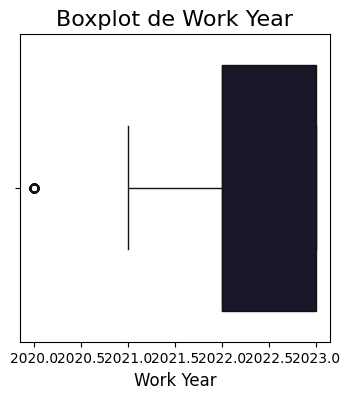

In [62]:
# Primero de Work Year

# Definir la paleta de colores
palette = sns.color_palette("cubehelix", n_colors=10)# Crear un boxplot para 'work_year'

plt.figure(figsize=(4, 4))
sns.boxplot(x=df['work_year'], palette=palette)

# Títulos y etiquetas
plt.title('Boxplot de Work Year', fontsize=16)
plt.xlabel('Work Year', fontsize=12)

# Mostrar gráfico
plt.show()

En este caso como considera outlier el año 2020 pero no hay fundamento en eso, lo ajustamos para que no lo considere outlier

In [63]:
# Calcular el IQR
Q1 = df['work_year'].quantile(0.25)
Q3 = df['work_year'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites ajustados
lower_limit = Q1 - 2.5 * IQR  # Aumenta o disminuye el 2.5 para ajustarlo
upper_limit = Q3 + 2.5 * IQR  # Aumenta o disminuye el 2.5 para ajustarlo

# Filtrar los outliers con los nuevos límites
outliers_work_year = df[(df['work_year'] < lower_limit) | (df['work_year'] > upper_limit)]
print("Outliers ajustados en work_year:", outliers_work_year)

Outliers ajustados en work_year: Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, salary, salary_currency, salary_in_usd, employee_residence, remote_ratio, company_location, company_size]
Index: []


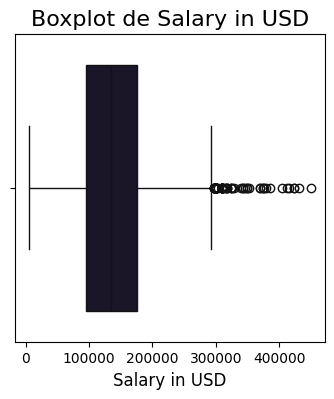

In [104]:
# Miramos los outliers de la variable target

# Definir la paleta de colores
palette = sns.color_palette("cubehelix", n_colors=10)

# Crear un boxplot para 'salary_in_usd'
plt.figure(figsize=(4, 4))
sns.boxplot(x=df['salary_in_usd'], palette=palette)

# Títulos y etiquetas
plt.title('Boxplot de Salary in USD', fontsize=16)
plt.xlabel('Salary in USD', fontsize=12)

# Mostrar gráfico
plt.show()

In [66]:
# Primero, definimos una función para calcular los outliers de nuestra variable target usando el IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar los outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Detectar outliers en 'Salary_in_USD'
outliers_salary_usd = detect_outliers(df, 'salary_in_usd')
print("Outliers en 'Salary_in_USD':")
print(outliers_salary_usd[['salary_in_usd']])


Outliers en 'Salary_in_USD':
      salary_in_usd
33           342810
68           309400
83           300000
133          342300
145          318300
...             ...
3522         450000
3675         416000
3697         325000
3747         423000
3750         412000

[63 rows x 1 columns]


In [67]:
# Índices de los outliers de Salary in USD que mencionas
outlier_indices = [33, 68, 83, 133, 145, 3522, 3675, 3697, 3747, 3750]

# Filtrar los registros correspondientes a estos outliers y mostrar las columnas relevantes
outlier_data = df.iloc[outlier_indices][['job_title', 'salary_in_usd', 'work_year', 'employee_residence']]
outlier_data

,job_title,salary_in_usd,work_year,employee_residence
33,Computer Vision Engineer,342810,2023,US
68,Applied Scientist,309400,2023,US
83,AI Developer,300000,2022,IN
133,Machine Learning Engineer,342300,2023,US
145,Machine Learning Engineer,318300,2023,US
3522,Research Scientist,450000,2020,US
3675,Principal Data Scientist,416000,2021,US
3697,Director of Data Science,325000,2020,US
3747,Applied Machine Learning Scientist,423000,2021,US
3750,Data Scientist,412000,2020,US


En este caso, parece que los outliers son legítimos y representan roles profesionales de alto nivel.

Por tanto **no** los eliminamos, pero les aplicaremos una transformación logarítmica o un escalado para asegurarnos de que no distorsionen la PCA o el rendimiento de los modelos de Machine Learning. 

Esto nos permitirá trabajar con estos outliers sin perder validez en el análisis y predicción.

#### 2.3 Análisis categórico

In [68]:
# Agrupamos todas las variables categóricas
categorical_cols = ['experience_level', 'employment_type', 'job_title', 
                    'salary_currency', 'employee_residence', 'company_location', 'company_size']

# Calculamos la cardinalidad en porcentaje de las variables categóricas:
for col in categorical_cols:
    print(f"\nCardinalidad para {col}:")
    cardinality = df[col].nunique()  # Calcula la cardinalidad de la variable
    total = len(df[col])  # Total de elementos de la columna
    cardinality_percentage = (cardinality / total) * 100  # Porcentaje de cardinalidad respecto al total
    print(f"Cardinalidad: {cardinality} valores únicos")
    print(f"Porcentaje de la cardinalidad: {cardinality_percentage:.2f}%")


Cardinalidad para experience_level:
Cardinalidad: 4 valores únicos
Porcentaje de la cardinalidad: 0.11%

Cardinalidad para employment_type:
Cardinalidad: 4 valores únicos
Porcentaje de la cardinalidad: 0.11%

Cardinalidad para job_title:
Cardinalidad: 93 valores únicos
Porcentaje de la cardinalidad: 2.48%

Cardinalidad para salary_currency:
Cardinalidad: 20 valores únicos
Porcentaje de la cardinalidad: 0.53%

Cardinalidad para employee_residence:
Cardinalidad: 78 valores únicos
Porcentaje de la cardinalidad: 2.08%

Cardinalidad para company_location:
Cardinalidad: 72 valores únicos
Porcentaje de la cardinalidad: 1.92%

Cardinalidad para company_size:
Cardinalidad: 3 valores únicos
Porcentaje de la cardinalidad: 0.08%


__Descripción exahustiva de las variables categóricas:__

➡️ **Experience Level (4 categorías):** *Junior, Mid, Senior, Executive*. Clasificación de nivel de experiencia de los empleados.

➡️ **Employment Type (4 categorías):** *Full-time, Part-time, Contract, y otra modalidad*. Diferentes tipos de contrato laboral.

➡️ **Job Title (93 categorías):** Gran diversidad de roles dentro de la ciencia de datos.

➡️ **Salary Currency (20 categorías):** Variedad de monedas reflejando la globalización del mercado laboral.

➡️ **Employee Residence (78 categorías):** Diversidad geográfica, empleados ubicados en múltiples países.

➡️ **Company Location (72 categorías):** Empresas ubicadas en varios países, indicando una distribución global.

➡️ **Company Size (3 categorías):** Pequeñas, medianas y grandes empresas, con implicaciones en salario y beneficios.

In [69]:
# Definir las variables categóricas
categorical_vars = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size','salary_currency']

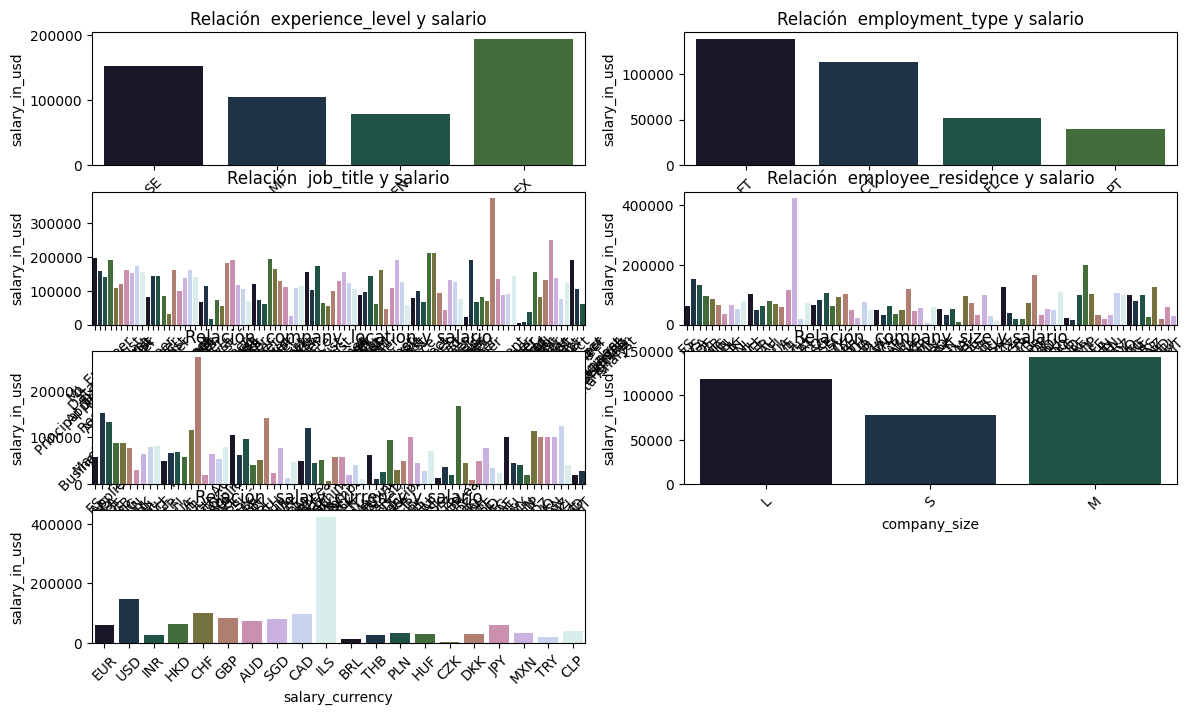

In [70]:
# Visualización de las variables categóricas

palette = sns.color_palette("cubehelix", n_colors=10)
plt.figure(figsize=(14, 10))

# Graficar la relación entre las variables categóricas y el salario en USD (usando el promedio)
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(5, 2, i)  # Crear una cuadrícula 2x3 para los gráficos
    sns.barplot(x=var, y='salary_in_usd', data=df, estimator='mean', ci=None, palette=palette)
    plt.xticks(rotation=45)
    plt.title(f'Relación  {var} y salario')

plt.tight_layout()
plt.show()

Para cada variable categórica que tiene muchos valores únicos (como *employee_residence*, *company_location*, y *job_title*), vamos a filtrar y mostrar solo los 10 valores más frecuentes (más repetidos).

Luego, representamos estos 10 valores en un gráfico de barras para ver cómo se distribuye el salario (*salary_in_usd*) en cada uno de esos valores más frecuentes.

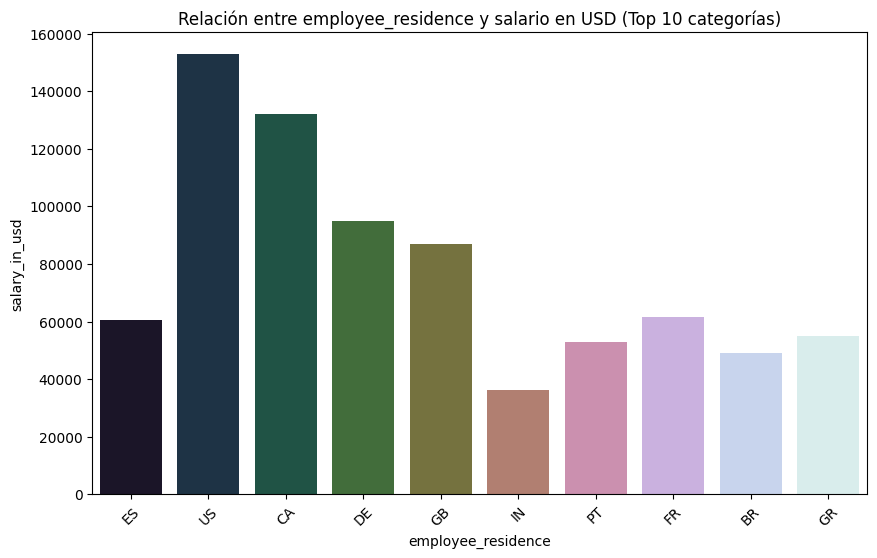

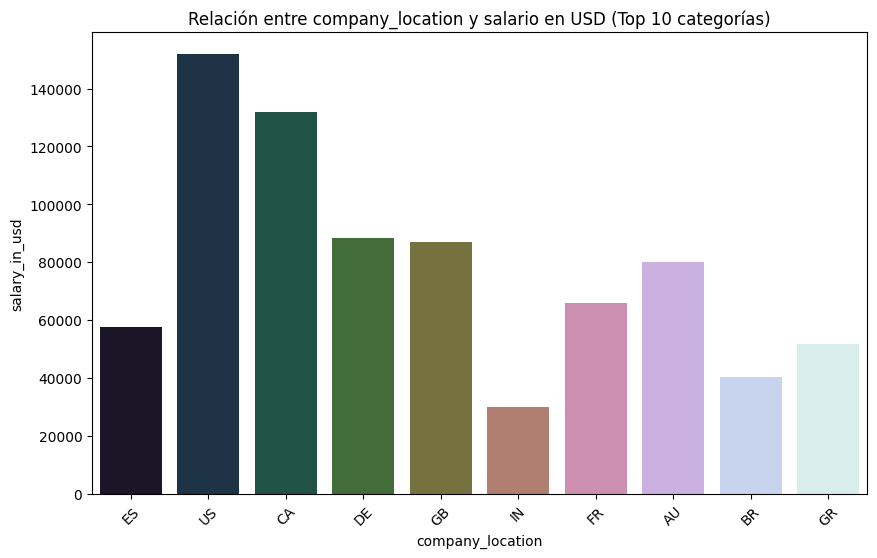

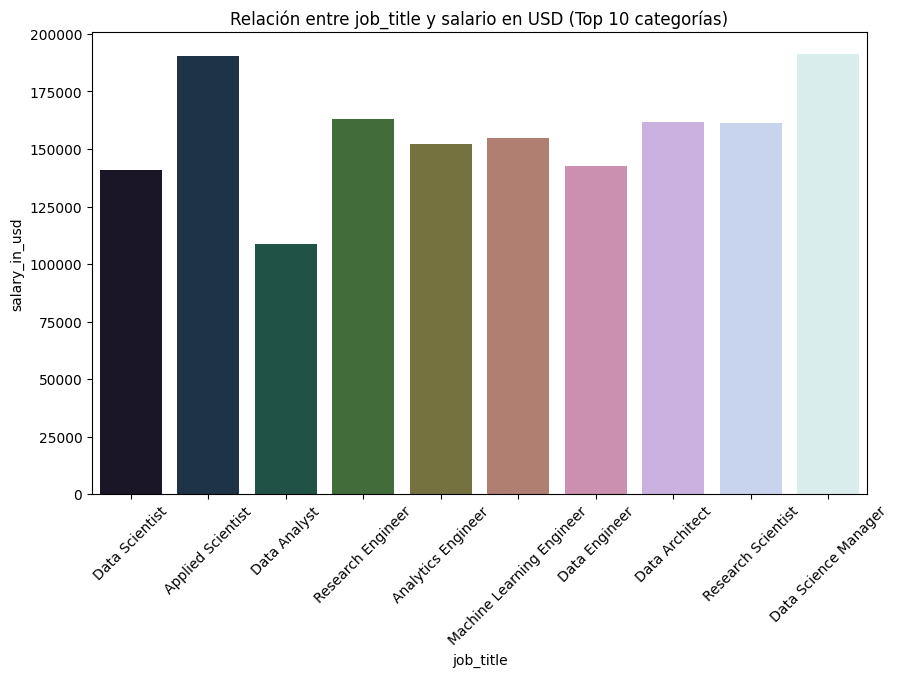

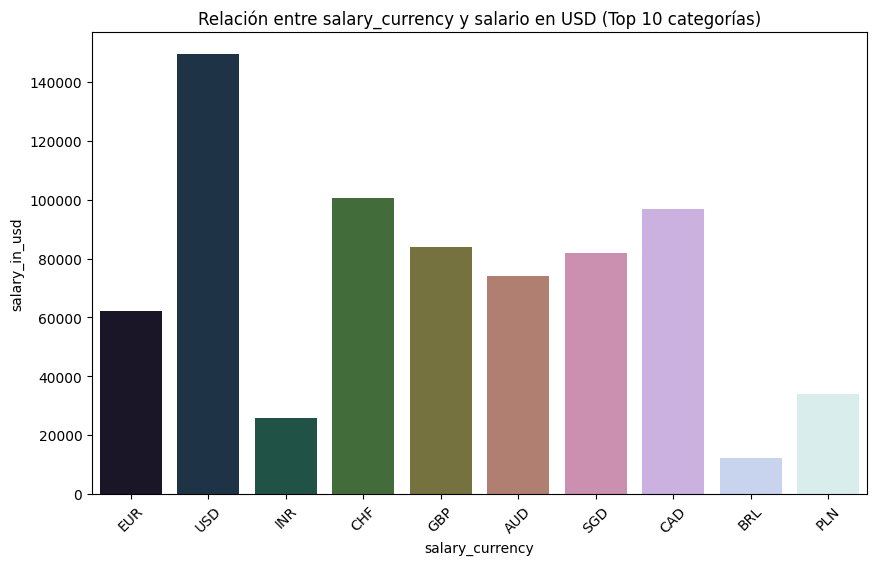

In [71]:
# Función para graficar las 10 categorías más frecuentes en una variable categórica
def plot_top_10_categories(df, column_name):
    # Obtener las 10 categorías más frecuentes
    top_10 = df[column_name].value_counts().nlargest(10).index
    
    # Filtrar el dataset para que solo contenga esos 10 valores más frecuentes
    df_filtered = df[df[column_name].isin(top_10)]
    
    # Graficar el salario medio de cada una de las 10 categorías más frecuentes
    palette = sns.color_palette("cubehelix", n_colors=10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y='salary_in_usd', data=df_filtered, estimator='mean', ci=None, palette=palette)
    plt.xticks(rotation=45)
    plt.title(f'Relación entre {column_name} y salario en USD (Top 10 categorías)')
    plt.show()

# Graficar las 10 categorías más frecuentes de cada variable
categorical_vars = ['employee_residence', 'company_location', 'job_title','salary_currency']

for var in categorical_vars:
    plot_top_10_categories(df, var)

1. *Relación entre Experience Level y Salario*:  
   Los roles con más experiencia, como *X (Executive o Expert)*, tienen una mayor correlación con salarios más altos. Es decir, a mayor experiencia, mayor salario.

2. *Relación entre Employment Type y Salario*:  
   Las posiciones *Full-Time (FT)* tienen salarios más altos que las de *Contract (CT)*. Cuanto más tiempo trabajes, más alto es el salario.

3. *Relación entre Company Size y Salario*:  
   Las *empresas medianas* ofrecen salarios más competitivos que las grandes empresas.

4. *Relación entre Employee Residence y Salario*:  
   Los empleados ganan más en *EE. UU.*, seguidos de *Canadá*, *Alemania* y *Reino Unido*, mientras que *Francia* y *España* están a la cola, aunque se están poniendo al día.

5. *Relación entre Company Location y Salario*:  
   Las empresas ubicadas en *EE. UU.* y *Canadá* ofrecen los salarios más altos, seguido por *Alemania*, *Reino Unido* y *Australia*.

6. *Relación entre Job Title y Salario*:  
   Las personas que más cobran son las que tienen los siguientes cargos:
   - *Data Science Manager*: Lidera equipos y gestiona proyectos de ciencia de datos.
   - *Applied Scientist*: Aplica ciencias para resolver problemas prácticos con IA.
   - *Research Engineer*: Desarrolla e implementa soluciones innovadoras.
   - *Data Architect*: Diseña la estructura de las bases de datos.
   - *Research Scientist*: Realiza investigaciones científicas profundas.

In [72]:
# Realizamos el ANOVA para cada variable categórica en relación con la variable 'salary_in_usd'
for col in categorical_cols:
    # Realizamos ANOVA para cada categoría comparada con 'salary_in_usd'
    print(f"\nANOVA para la variable: {col}")
    groups = [df[df[col] == category]['salary_in_usd'] for category in df[col].unique()]
    
    # Realizamos el test de ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    print(f"Estadístico F: {f_stat}")
    print(f"Valor p: {p_value}")
    
    # Interpretación del valor p
    if p_value < 0.05:
        print(f"Resultado: Existe una diferencia significativa entre los grupos de {col}.")
    else:
        print(f"Resultado: No hay diferencia significativa entre los grupos de {col}.")


ANOVA para la variable: experience_level
Estadístico F: 310.84425170411885
Valor p: 3.0989451417587622e-180
Resultado: Existe una diferencia significativa entre los grupos de experience_level.

ANOVA para la variable: employment_type
Estadístico F: 20.850249944174553
Valor p: 2.1508841037278986e-13
Resultado: Existe una diferencia significativa entre los grupos de employment_type.

ANOVA para la variable: job_title
Estadístico F: 6.994979915062784
Valor p: 1.4805358300187946e-75
Resultado: Existe una diferencia significativa entre los grupos de job_title.

ANOVA para la variable: salary_currency
Estadístico F: 60.833914238777346
Valor p: 5.599609240599029e-202
Resultado: Existe una diferencia significativa entre los grupos de salary_currency.

ANOVA para la variable: employee_residence
Estadístico F: 19.52859994361009
Valor p: 6.198150859506961e-216
Resultado: Existe una diferencia significativa entre los grupos de employee_residence.

ANOVA para la variable: company_location
Estadíst

En general, los resultados de ANOVA nos dicen que las variables categóricas que hemos analizado (nivel de experiencia, tipo de empleo, cargo, moneda de salario, y tamaño de la empresa) **están relacionadas de forma significativa con el salario**. 

Esto implica que cada una de estas variables puede influir de manera importante en la variación del salario, y deberían ser consideradas al momento de analizar o predecir los sueldos en un contexto de ciencia de datos.

## 3. Separación y Codificación

In [73]:
df_original=df.copy()

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


#### 3.1 Transformaciones

Vamos a tranformar las variables categoricas para poder usarlas tanto en la PCA como en el modelo supervisado:
* Primero creamos dos mapeos de las categorias que solamente tienen pocos valores çunicos como la experiencia que tiene 4 valores la transformamos en ordinal ya que va por orden de experiencia.
* El tamaño de empresa también la tansformamos en ordinal ya que sus valores únicos son 3: Small, Medium y Large.
* El resto las pasamos por el pipeline.  Sin embargo, 4 de estas variables las agrupamos previamente por salario con una funcion para que estén mejor asignadas:  *company_ location*, *job_title*, *employment type*, *employee residence*.

In [75]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [76]:
# Mapeo de Experience Level
experience_level_map = {
    'SE': 1,  # Junior
    'MI': 2,  # Mid-level
    'EX': 3,  # Senior
    'EN': 4   # Expert
}

# Mapeo de Company Size (Esto también podría ser OneHotEncoding si no hay un orden claro)
company_size_map = {
    'S': 1,   # Small
    'M': 2,   # Medium
    'L': 3    # Large
}

df['experience_level_encoded'] = df['experience_level'].map(experience_level_map)
df['company_size_encoded'] = df['company_size'].map(company_size_map)

In [77]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size',
       'experience_level_encoded', 'company_size_encoded'],
      dtype='object')

In [78]:
# Eliminamos las columnas categóricas porque ya las hemos convertido en numéricas
df=df.drop(['experience_level','company_size'], axis=1)
df

,work_year,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,experience_level_encoded,company_size_encoded
0,2023,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,1,3
1,2023,CT,ML Engineer,30000,USD,30000,US,100,US,2,1
2,2023,CT,ML Engineer,25500,USD,25500,US,100,US,2,1
3,2023,FT,Data Scientist,175000,USD,175000,CA,100,CA,1,2
4,2023,FT,Data Scientist,120000,USD,120000,CA,100,CA,1,2
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,FT,Data Scientist,412000,USD,412000,US,100,US,1,3
3751,2021,FT,Principal Data Scientist,151000,USD,151000,US,100,US,2,3
3752,2020,FT,Data Scientist,105000,USD,105000,US,100,US,4,1
3753,2020,CT,Business Data Analyst,100000,USD,100000,US,100,US,4,3


In [105]:
# Agrupamos las variables por salarios
def group_by_salary(df, column):
    # Definir los intervalos de salario
    salary_bins = [0, 60000, 90000, 150000, 200000, float('inf')]
    salary_labels = ['Low', 'Medium', 'High', 'Very High', 'Extremely High']
    
    # Crear la nueva columna con los grupos basados en salario
    df[column + '_grouped'] = pd.cut(df['salary_in_usd'], bins=salary_bins, labels=salary_labels, right=False)
    return df

# Agrupar las variables que tienen alto cardinalidad por salario
df = group_by_salary(df, 'job_title')
df = group_by_salary(df, 'employee_residence')
df = group_by_salary(df, 'company_location')
df = group_by_salary(df, 'salary_currency')

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   work_year                   3755 non-null   int64   
 1   employment_type             3755 non-null   object  
 2   job_title                   3755 non-null   object  
 3   salary                      3755 non-null   int64   
 4   salary_currency             3755 non-null   object  
 5   salary_in_usd               3755 non-null   int64   
 6   employee_residence          3755 non-null   object  
 7   remote_ratio                3755 non-null   int64   
 8   company_location            3755 non-null   object  
 9   experience_level_encoded    3755 non-null   int64   
 10  company_size_encoded        3755 non-null   int64   
 11  job_title_grouped           3755 non-null   category
 12  employee_residence_grouped  3755 non-null   category
 13  company_location_g

In [81]:
# Creamos una copia de seguridad
df_t=df.copy()

In [82]:
# Eliminamos las variables que hemos agrupado con la función anterior
df=df.drop(['job_title','salary_currency', 'employee_residence','company_location'],axis=1)

In [83]:
# Volvemos a seleccionar las columnas categóricas
categorical_columns = ['employment_type','experience_level_encoded','company_size_encoded', 'job_title_grouped', 'employee_residence_grouped',
                       'company_location_grouped', 'salary_currency_grouped',]

#### 3.2 PIPELINES

In [84]:
# Creamos un transformer para OneHotEncoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Pipeline para transformar las variables categóricas
categorical_transformer = Pipeline(steps=[
    ('impute_mode', SimpleImputer(strategy='most_frequent')),
    ('encoder', encoder)
])

In [85]:
# Crear una función para el logaritmo
def log_transform(x):
    return np.log1p(x)  # Usamos log1p para evitar problemas con ceros

# Transformar salary_in_usd y otras variables numéricas
numerical_columns = ['salary_in_usd', 'salary','remote_ratio','work_year']

# Crear el pipeline para las transformaciones numéricas
numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('log', FunctionTransformer(log_transform, validate=False)),
    ('scaler', MinMaxScaler())
])

Hacemos la separacion en train y en test y después incluimos los pipelines que hemos creado tanto para las  numéricas como para las categoricas en un pipeline final que es el que pasamos a los modelos.

In [86]:
# Dividir los datos en X (características) e y (target)
# # X = df.drop('salary_in_usd', axis=1)  # Suponiendo que quieres predecir 'salary_in_usd'
# X = df.copy()
# y = df['salary_in_usd']

# Dividir en conjunto de entrenamiento y test
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

train_set.to_csv("regresion_train.csv")
test_set.to_csv("regresion_test.csv")

X_train = train_set.copy()
y_train = train_set['salary_in_usd']
X_test = test_set.copy()
y_test = test_set['salary_in_usd']

# Crear el ColumnTransformer para aplicar las transformaciones a las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ], remainder = 'drop')

# Crear el pipeline final
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Ajustar el pipeline a los datos de entrenamiento
pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x11782dda0>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['salary_in_usd', 'salary',
                                                   'remote_ratio',
                                                   'work_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['employment_type',
                                                   'experience_level_encoded',
                                                   'company_size_encoded',
                                                   'job_title_grouped',
                                                   'employee_residence_grouped',
                                                   'company_location_grouped',
                                                   'salary_currency_grouped'])]))])

In [87]:
# Entrenamos el modelo con el pipeline
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [88]:
# El pipeline nos devuelve un array que admitirán los modelos de predicción
X_train_transformed

array([[0.44016421, 0.20672853, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.75708843, 0.37872701, 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.66378683, 0.32979653, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.91669402, 0.46242951, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.55925788, 0.25537107, 0.8519443 , ..., 0.        , 1.        ,
        0.        ],
       [0.62495406, 0.30363781, 1.        , ..., 0.        , 1.        ,
        0.        ]])

##### PIPELINE GUARDADO

In [89]:
# Guardar el pipeline en un archivo
joblib.dump(pipeline, "pipeline_preprocesamiento.joblib")

# Para cargarlo más adelante:
# pipeline_cargado = joblib.load("pipeline_preprocesamiento.joblib")

['pipeline_preprocesamiento.joblib']

## 4. MODELOS 

En primer lugar hacemos un diccionario con los modelos y sus resultados de validación cruzada para encontrar el **mejor modelo**:

In [90]:
# Diccionario de modelos
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1)
}

# Evaluación con validación cruzada
cv_results = {}

for name, model in models.items():
    try:
        score = np.mean(-cross_val_score(model, X_train_transformed, y_train, cv=5, scoring='neg_root_mean_squared_error'))
        cv_results[name] = score
        print(f"{name}: RMSE {score:.2f}")
    except Exception as e:
        print(f"⚠️ Error en {name}: {e}")

# Mostrar resultados
print("\nResultados de validación cruzada:", cv_results)

Linear Regression: RMSE 15649.70
Random Forest: RMSE 1089.40
Gradient Boosting: RMSE 980.71
XGBoost: RMSE 1867.00
LightGBM: RMSE 2897.70

Resultados de validación cruzada: {'Linear Regression': np.float64(15649.703346616856), 'Random Forest': np.float64(1089.3977138161324), 'Gradient Boosting': np.float64(980.7141334555469), 'XGBoost': np.float64(1867.0046630859374), 'LightGBM': np.float64(2897.7009706755775)}


Los mejores son  **Gradient Boosting** y  **Random Forest**, así que elegimos Radom Forest como modelo supervisado lo hago con pca sale peor y entreno el modelo para predecir, luego lo hare con el gradient boosting que solo tienen un error de 980 euros buscare sus hiperparametros lo optimizo hago predicciones y los comparo ambos 

Pero primero probaremos con un modelo no supervisado como la PCA para ver si la dimensionalidad afecta al entrenamiento del modelo

#### 4.1 📊 Modelo No supervisado - PCA

In [106]:
# Aplicamos PCA (dejamos 95% de la varianza)
pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)

# Volvemos a hacer Grid Search con PCA
random_search_pca = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Entrenamos con los datos transformados por PCA
random_search_pca.fit(X_train_pca, y_train)

# Mejor modelo con PCA
best_rf_pca = random_search_pca.best_estimator_
print("Mejores hiperparámetros con PCA:", random_search_pca.best_params_)
print("Mejor RMSE con PCA:", -random_search_pca.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; tot

Obtenemos un **RMSE 12331** mayor que el del la base line, por lo tanto descartamos la PCA.

#### 4.2 🔍 Modelo Supervisado - Random Forest

In [91]:
# Definir el modelo base
rf = RandomForestRegressor(random_state=42)

# Definir los hiperparámetros a probar
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV para optimizar hiperparámetros
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Ejecutar la búsqueda de hiperparámetros
random_search.fit(X_train_transformed, y_train)

# Mejor modelo encontrado
best_rf = random_search.best_estimator_
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor RMSE:", -random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; tot

y aqui entrenamos con los mejores parametros y hare las predicciones a ver que tal salen

In [93]:
# Entrenar el modelo con los mejores parámetros obtenidos
best_rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=10, min_samples_leaf=2, bootstrap=False)
best_rf.fit(X_train_transformed, y_train)

RandomForestRegressor(bootstrap=False, min_samples_leaf=2, min_samples_split=10)

In [94]:
y_pred=best_rf.predict(X_test_transformed)

In [95]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rf = np.sqrt(mean_absolute_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)

print(f"Random Forest - RMSE: {rmse_rf}")
print(f"Random Forest - MAE: {mae_rf}")
print(f"Random Forest - R2: {r2_rf}")

Random Forest - RMSE: 671.5438847913568
Random Forest - MAE: 13.695459705250661
Random Forest - R2: 0.9998857661608143


El modelo de *Random Forest* optimizado ha mostrado un excelente desempeño en la predicción de los salarios de los data analistas en 2023, con un **R² de 0.99**, un **RMSE de 671.80 USD** y un **MAE de 13.69 USD**. 

In [96]:
# Definir el modelo base
gb = GradientBoostingRegressor(random_state=42)

# Definir el grid de hiperparámetros a probar
param_grid = {
    'n_estimators': [100,200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5,10],
    'min_samples_split': [2, 5,10],
    'min_samples_leaf': [1, 2,4]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Métrica de evaluación
    cv=3,  # Validación cruzada con 5 folds
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda de hiperparámetros en los datos transformados
grid_search.fit(X_train_transformed, y_train)

# Guardar el mejor modelo encontrado
best_gb = grid_search.best_estimator_

# Imprimir los mejores hiperparámetros y su error asociado
print("Mejores hiperparámetros para Gradient Boosting:", grid_search.best_params_)
print("Mejor RMSE encontrado:", -grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=2

In [97]:
# Entrenar el modelo con los mejores hiperparámetros encontrados
best_gb.fit(X_train_transformed, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred_gb = best_gb.predict(X_test_transformed)

# Evaluar el modelo con diferentes métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rmse_gb =np.sqrt( mean_squared_error(y_test, y_pred_gb))
mae_gb = np.sqrt(mean_absolute_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - RMSE: {rmse_gb}")
print(f"Gradient Boosting - MAE: {mae_gb}")
print(f"Gradient Boosting - R2: {r2_gb}")

Gradient Boosting - RMSE: 383.8680956592583
Gradient Boosting - MAE: 12.776626438896177
Gradient Boosting - R2: 0.9999626741237484


El modelo *Gradient Boosting* arrojó un **RMSE de 383.86 USD**, un **MAE de 12.77 USD** y también un **R² de 0.99**.

## 5. 🏁 Conclusiones  

### Random Forest:
Como decíamos antes, modelo de *Random Forest* optimizado ha mostrado un excelente desempeño en la predicción de los salarios de los data analistas en 2023, con un **R² de 0.99**, un **RMSE de 671.80 USD** y un **MAE de 13.69 USD**. 

Estos resultados indican que el modelo se ajusta muy bien a los datos, explicando casi toda la variabilidad en los salarios. Dado que la distribución de los salarios es amplia, con valores que van desde 5.132 USD hasta 450.000 USD, los errores son relativamente pequeños, lo que refleja una **alta precisión** en las predicciones.

Además, decidimos no tratar los outliers porque, al analizar las variables categóricas, observamos que los puestos de trabajo con los salarios más altos se correspondían con esos outliers. Por lo tanto, consideramos que debía ser parte del análisis, lo que creemos que ha mejorado la precisión del modelo al capturar adecuadamente estos valores extremos.

### Gradient Boosting:
*Gradient Boosting* arrojó un **RMSE de 383.86 USD**, un **MAE de 12.77 USD** y también un **R² de 0.99**.

La notable reducción del RMSE (de **671 USD a 384 USD** aproximadamente) significa que, en promedio, el error en las predicciones se ha disminuido considerablemente, lo que se traduce en predicciones más precisas.

Además, el MAE ligeramente inferior en *Gradient Boosting* refuerza que las diferencias absolutas entre las predicciones y los valores reales son menores.

Con ambos modelos explicando el 99% de la variabilidad (R²=0.99), se evidencia que *Gradient Boosting* **mejora el desempeño al reducir significativamente el error medio**.

Por ello, *Gradient Boosting* es preferible en este caso, ya que produce predicciones más cercanas a los valores reales, lo que resulta especialmente relevante en la estimación de salarios donde una **diferencia de varios cientos de dólares es crítica**.

# añadir leyenda

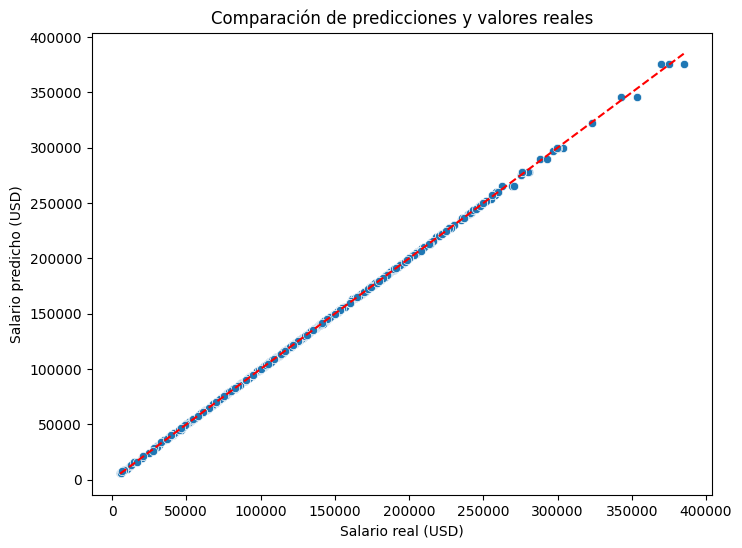

In [98]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Salario real (USD)")
plt.ylabel("Salario predicho (USD)")
plt.title("Comparación de predicciones y valores reales")
plt.show()

El gráfico de dispersión que compara las predicciones con los valores reales muestra una recta casi perfecta para la mayor parte de los datos, lo que indica que el modelo predice de forma muy precisa. 

Sin embargo, a partir de aproximadamente **280.000 USD**, las predicciones comienzan a desviarse un poco de la línea ideal, sugiriendo que en ese rango el modelo acierta algo menos. Esto puede deberse a que hay menos datos de entrenamiento en esos valores altos o a una mayor variabilidad en ese segmento.

## 6. Anexos

In [99]:
# Obtener los nombres de las columnas numéricas y categóricas transformadas
num_features = numerical_columns  # Ya definidas antes
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_columns)

# Unir ambas listas de nombres de columnas
all_features = list(num_features) + list(cat_features)

# Obtener la importancia de las características del modelo
feature_importances = best_gb.feature_importances_

# Crear DataFrame con la importancia de cada variable
importances_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})

# Ordenar de mayor a menor importancia
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Mostrar las 10 más importantes
print(importances_df.head(10))

                                    Feature    Importance
0                             salary_in_usd  9.826632e-01
1                                    salary  1.706448e-02
19              job_title_grouped_Very High  1.887809e-04
25  company_location_grouped_Extremely High  7.567505e-05
3                                 work_year  3.706507e-06
9                experience_level_encoded_2  3.305647e-06
8                experience_level_encoded_1  2.748314e-07
30   salary_currency_grouped_Extremely High  2.527481e-07
14                   company_size_encoded_3  1.406388e-07
4                        employment_type_CT  6.084754e-08


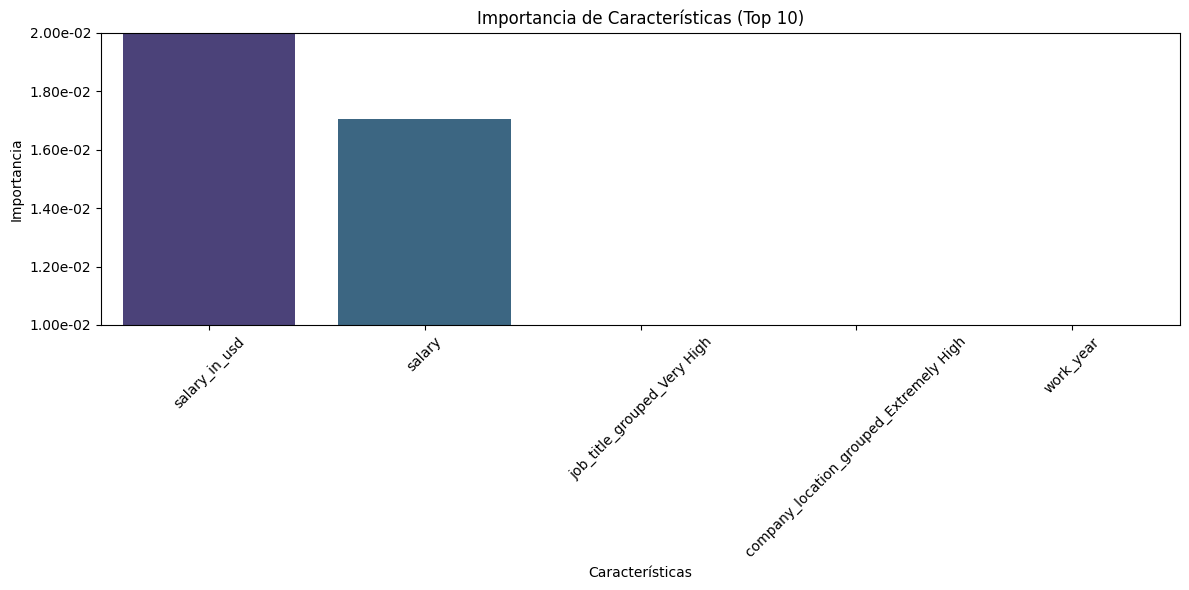

In [100]:
# Supongamos que importances_df ya tiene las columnas 'Feature' e 'Importance'
top_features = importances_df.head(5)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_features, x='Feature', y='Importance', palette='viridis')
plt.title("Importancia de Características (Top 10)")
plt.xlabel("Características")
plt.ylabel("Importancia")
# Formateamos la escala del eje Y en notación científica para ver los pequeños valores
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2e}'))
# Ajustamos los límites del eje Y para un rango más reducido (por ejemplo, de 0.01 a 0.02)
plt.ylim(0.01, 0.02)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1.	El análisis de la importancia de variables muestra que “salary_in_usd” y “salary” son las características más relevantes, lo que destaca la centralidad de la información salarial en el desempeño del modelo.
2.	Esto indica que tanto la forma original del salario como su conversión a dólares son críticas para predecir con precisión, validando su peso en el análisis predictivo.

In [101]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0)
    }
    model = GradientBoostingRegressor(**params, random_state=42)
    score = cross_val_score(model, X_train_transformed, y_train, cv=3,
                            scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("Mejores hiperparámetros (Gradient Boosting):", study.best_params)

[I 2025-03-18 19:53:01,501] A new study created in memory with name: no-name-ffb7efc6-d29b-42c1-a754-82b0bbb2643e
[I 2025-03-18 19:53:01,824] Trial 0 finished with value: 8684.004949852928 and parameters: {'n_estimators': 179, 'learning_rate': 0.011215502172950167, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.8484636441584412}. Best is trial 0 with value: 8684.004949852928.
[I 2025-03-18 19:53:02,790] Trial 1 finished with value: 1390.852518918007 and parameters: {'n_estimators': 256, 'learning_rate': 0.05277984218505389, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.9620251591864798}. Best is trial 1 with value: 1390.852518918007.
[I 2025-03-18 19:53:03,115] Trial 2 finished with value: 1041.151392465773 and parameters: {'n_estimators': 171, 'learning_rate': 0.048171577912472945, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.9769861871134312}. Best is trial 2 with value: 1041.151392465773

Mejores hiperparámetros (Gradient Boosting): {'n_estimators': 101, 'learning_rate': 0.055846069059964525, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.8129661479331434}


In [102]:
best_gb = GradientBoostingRegressor(
    n_estimators=262,
    learning_rate=0.087,
    max_depth=9,
    min_samples_split=8,
    min_samples_leaf=2,
    subsample=0.9580,
    random_state=42
)

# Entrena el modelo con tus datos transformados
best_gb.fit(X_train_transformed, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = best_gb.predict(X_test_transformed)

# Calcula las métricas, por ejemplo, RMSE, MAE y R²
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 375.0099808745602
MAE: 68.33467587020628
R²: 0.99996437690667


Tras aplicar la optimización bayesiana con Optuna, se obtuvieron los siguientes hiperparámetros óptimos para el modelo de Gradient Boosting: 262 estimadores, learning rate de 0,087, max_depth de 9, min_samples_split de 8, min_samples_leaf de 2 y subsample de 0,9580. Con estos parámetros, el modelo logró un RMSE de 383,36 USD y un R² de 0,99, lo que indica un ajuste excelente en la mayoría del rango salarial. Aunque el MAE resultó ser 69,58 USD (algo mayor que el 12,77 USD obtenido anteriormente), se sugiere que este incremento podría deberse a una mayor sensibilidad en la predicción de los errores medios, sin afectar la capacidad explicativa global del modelo. En conjunto, estos resultados indican que el Gradient Boosting optimizado es el modelo más adecuado para predecir los salarios de data analistas en 2023.

In [103]:
# Definimos una función para evaluar el modelo con validación cruzada
def evaluar_modelo(modelo, X, y, cv=5):
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(-cross_val_score(modelo, X, y, scoring='neg_mean_squared_error', cv=cv))
    
    # MAE (Mean Absolute Error)
    mae = -cross_val_score(modelo, X, y, scoring='neg_mean_absolute_error', cv=cv)
    
    # R² (Coeficiente de determinación)
    r2 = cross_val_score(modelo, X, y, scoring='r2', cv=cv)
    
    print(f"Resultados de Validación Cruzada ({cv}-fold) para {modelo.__class__.__name__}:")
    print(f"RMSE medio: {rmse.mean():.2f} ± {rmse.std():.2f}")
    print(f"MAE medio: {mae.mean():.2f} ± {mae.std():.2f}")
    print(f"R² medio: {r2.mean():.4f} ± {r2.std():.4f}")
    print("-" * 50)

# Evaluamos Random Forest optimizado
evaluar_modelo(best_rf, X_train_transformed, y_train)

# Evaluamos Gradient Boosting optimizado
evaluar_modelo(best_gb, X_train_transformed, y_train)

Resultados de Validación Cruzada (5-fold) para RandomForestRegressor:
RMSE medio: 1943.81 ± 720.07
MAE medio: 298.86 ± 58.41
R² medio: 0.9989 ± 0.0008
--------------------------------------------------
Resultados de Validación Cruzada (5-fold) para GradientBoostingRegressor:
RMSE medio: 994.14 ± 574.23
MAE medio: 114.23 ± 40.22
R² medio: 0.9997 ± 0.0003
--------------------------------------------------
